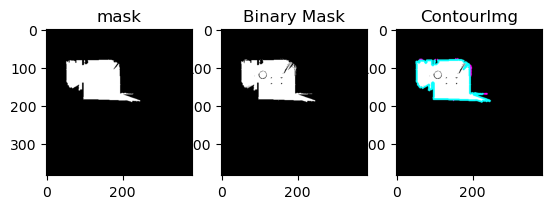

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import glob
import imutils
from skimage.metrics import structural_similarity as SIMM
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
from PIL import Image, ImageDraw, ImageFilter

def getMapEdge(img,showFeatures = False):
    gray = img[:,:,0]

    hist,bin_edgs=np.histogram(gray,bins=50) #getting the histogram of the image
    bin_c=0.5*(bin_edgs[:-1]+bin_edgs[1:]) #getting all the centres of the bins of the histogram
    bin_threshold=sum(bin_c)/len(bin_c) #setting the threshold as average of all the bin centres

    bin_threshold += 48
    bin_threshold = 210

    # Denoise
    deNoise = cv2.bilateralFilter(gray,9,75,75) # blur but keeping edge
    deNoise = cv2.medianBlur(deNoise,5)
    deNoise = cv2.bilateralFilter(gray,9,75,75)

    # Get Bin Mask
    binary_mask = deNoise > bin_threshold #forming the binary image
    binary_mask.dtype='uint8' # convert binary_mask in type of true false to decimal array
    binMask = binary_mask
    binary_mask = np.array(binary_mask*255,dtype=np.uint8) # convert binary_mask in type of true false to decimal 0-255 array

    # Get Edge
    ## from bin
    blurBin = cv2.GaussianBlur(binary_mask,(3,3), 0, 0) 
    edged = cv2.Canny(blurBin, 100, 200)
    ## from gray
    edge_gray = cv2.Canny(gray, 200, 255)
    ## sharpen the grayscale even more and get edge via canny-gray
    sharpen_filter=np.array([[-1,-1,-1],
                    [-1,9,-1],
                    [-1,-1,-1]])
    ### applying kernels to the input image to get the sharpened image
    sharp_image=cv2.filter2D(deNoise,-1,sharpen_filter)
    edge_gray_sharp = cv2.Canny(sharp_image, 200, 255)

    # Find Contour
    # contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contourImg = cv2.bitwise_and(img, img, mask=binMask)
    ## approximate contour


    # Draw all contours
    cv2.drawContours(contourImg, contours, -1,  (255, 0, 255), 3) # -1 signifies drawing all contours

    ## Find the biggest Contour and draw it
    # draw the biggest contour (ContourMax) in cyan
    contourMax = max(contours, key = cv2.contourArea)
    cv2.drawContours(contourImg, contourMax, -1,  (9, 255, 255), 3) # -1 signifies drawing all contours
    # cv2.drawContours(mask, [contour], 0, (0,0,0), -1) # -1 fills contour's inside
    mask = np.zeros(img.shape, dtype='uint8')
    cv2.drawContours(mask, [contourMax], 0, (255,255,255), -1) # -1 fills contour's inside
    mask = [x / 255.0 for x in mask]

    # Get new bin Mask from Contour
    cv2.drawContours(
        image=binMask,
        contours=[contourMax],
        contourIdx=-1,
        color=(255,255,255),
        thickness=cv2.FILLED)
    # Get Image from AND with Mask
    binMask = np.array(binMask/255,dtype=np.uint8) # convert binary_mask in type of true false to decimal 0-255 array

    masked_Image = cv2.bitwise_and(img,img, mask= binMask)
    # Display
    if(showFeatures):
        fig = plt.figure()

        ax0 = fig.add_subplot(2,3,1)
        ax0.imshow(mask,cmap = 'gray')
        ax0.title.set_text('mask')

        ax1 = fig.add_subplot(2,3,2)
        ax1.imshow(binary_mask,cmap="gray")
        ax1.title.set_text('Binary Mask')

        ax2 = fig.add_subplot(2,3,3)
        ax2.imshow(contourImg)
        ax2.title.set_text('ContourImg')

    return [contourImg,masked_Image,mask]
    

def getImageFeature(img,showFeatures = True,bThresh = False):
    gray = img[:,:,0]

    hist,bin_edgs=np.histogram(gray,bins=50) #getting the histogram of the image
    bin_c=0.5*(bin_edgs[:-1]+bin_edgs[1:]) #getting all the centres of the bins of the histogram
    bin_threshold=sum(bin_c)/len(bin_c) #setting the threshold as average of all the bin centres

    bin_threshold += 48
    if(bThresh):
        bin_threshold = 50

    # Denoise
    deNoise = cv2.bilateralFilter(gray,9,75,75) # blur but keeping edge
    deNoise = cv2.medianBlur(deNoise,5)
    deNoise = cv2.bilateralFilter(gray,9,75,75)

    # Get Bin Mask
    binary_mask = deNoise > bin_threshold #forming the binary image
    binary_mask.dtype='uint8' # convert binary_mask in type of true false to decimal array
    binMask = binary_mask

    binary_mask.dtype='uint8' # convert binary_mask in type of true false to decimal 0-1 array
    binary_mask = np.array(binary_mask*255,dtype=np.uint8) # convert binary_mask in type of true false to decimal 0-255 array

    # Get Edge
    ## from bin
    # edged = cv2.Canny(binary_mask, 30, 200)
    blurBin = cv2.GaussianBlur(binary_mask,(3,3), 0, 0) 
    edged = cv2.Canny(blurBin, 100, 200)
    ## from gray
    edge_gray = cv2.Canny(gray, 200, 255)
    ## sharpen the grayscale even more and get edge via canny-gray
    sharpen_filter=np.array([[-1,-1,-1],
                    [-1,9,-1],
                    [-1,-1,-1]])
    ### applying kernels to the input image to get the sharpened image
    sharp_image=cv2.filter2D(deNoise,-1,sharpen_filter)
    edge_gray_sharp = cv2.Canny(sharp_image, 200, 255)

    # Find Contour
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contourImg = cv2.bitwise_and(img, img, mask=binMask)
    # contourImg = img.copy()
    ## approximate contour


    # Draw all contours
    cv2.drawContours(contourImg, contours, -1,  (255, 0, 255), 3) # -1 signifies drawing all contours


    # draw the biggest contour (ContourMax) in cyan
    contourMax = max(contours, key = cv2.contourArea)

    ## Draw the detecting rectangle
    x,y,w,h = cv2.boundingRect(contourMax)
    cv2.rectangle(contourImg,(x,y),(x+w,y+h),(0,255,0),2)

    ## Find the biggest Contour and draw it
    cv2.drawContours(contourImg, contourMax, -1,  (9, 255, 255), 3) # -1 signifies drawing all contours

    # Get new bin Mask from Contour
    cv2.drawContours(
        image=binMask,
        contours=[contourMax],
        contourIdx=-1,
        color=(255,255,255),
        thickness=cv2.FILLED)
    # Get Image from AND with Mask
    binMask = np.array(binMask/255,dtype=np.uint8) # convert binary_mask in type of true false to decimal 0-255 array
    masked_Image = cv2.bitwise_and(img,img, mask= binMask)

    # Get Image from AND with Mask

    masked_Image = cv2.bitwise_and(img,img, mask= binMask)
    # Display
    if(showFeatures):
        # print("Number of Contours found = " + str(len(contours)))

        fig = plt.figure()

        ax0 = fig.add_subplot(2,3,1)
        ax0.imshow(edged,cmap = 'gray')
        ax0.title.set_text('Edge Bin')

        ax1 = fig.add_subplot(2,3,2)
        ax1.imshow(binary_mask,cmap="gray")
        ax1.title.set_text('Binary Mask')

        ax2 = fig.add_subplot(2,3,3)
        ax2.imshow(contourImg)
        ax2.title.set_text('ContourImg')

        ax3 = fig.add_subplot(2,3,4)
        ax3.imshow(edge_gray,cmap="gray")
        ax3.title.set_text('Edge Gray')

        ax4 = fig.add_subplot(2,3,5)
        ax4.imshow(edge_gray_sharp,cmap='gray')
        ax4.title.set_text('Edge Gray-Sharpen')

        ax5 = fig.add_subplot(2,3,6)
        ax5.imshow(masked_Image)
        ax5.title.set_text('Maked Img')
    return [contourImg,masked_Image]
def getRegionMap(image1,image2,b_display = False):
    #GetMask
    result = image2.copy()
    result[image1 == 0] = 0
    result[image1 != 0] = image2[image1 != 0]
    image2 = result
    bin_threshold = 220
    binMask = image2 > bin_threshold #forming the binary image
    binary_mask = binMask
    binary_mask.dtype='uint8' # convert binary_mask in type of true false to decimal 0-1 array
    binary_mask = np.array(binary_mask*255,dtype=np.uint8) # convert binary_mask in type of true false to decimal 0-255 array
    
    mask = binMask
    result[mask == 0] = 0
    result[mask != 0] = image1[mask != 0]
    maskedImage1 = result

    if(b_display):
    # Display
        fig = plt.figure()

        ax3 = fig.add_subplot(1,2,1)
        ax3.imshow(image1,cmap='gray')
        ax3.title.set_text('map1')

        ax3 = fig.add_subplot(1,2,2)
        ax3.imshow(image2)
        ax3.title.set_text('map2')


        ax3 = fig.add_subplot(1,2,1)
        ax3.imshow(binary_mask,cmap='gray')
        ax3.title.set_text('Binary Difference Mask')
        ax3 = fig.add_subplot(1,2,2)
        ax3.imshow(maskedImage1,cmap='gray')
        ax3.title.set_text('maskedImage1')

    
    return [mask,maskedImage1]
def printDifferences(img1,img2,FigName="Differences"):
    b_haveAnomaly = False
    # get image copy for display purpose
    og1 = img1.copy()
    og2 = img2.copy()
    # convert to grayscale: 
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Compute SSIM between the 2 images
    (score, diff) = SIMM(img1_gray, img2_gray, full=True)
    diff = (diff * 255).astype("uint8") # diff is True-False rn, cvrt it to int (range 0-255)
    diff_box = cv2.merge([diff, diff, diff]) # allow it to have 3 channel for coloring purpose

    # Get Contours
    binaryThresh=0
    thresh = cv2.threshold(diff, binaryThresh, 255, cv2.THRESH_BINARY)[1]
    kernel = np.ones((5,5), np.uint8)  
    thresh = cv2.erode(thresh, kernel, iterations=1)  

    



    mask = np.zeros(img1.shape, dtype='uint8')
    # mask = (255-thresh)
    mask = diff < 10
    contourImg = img2.copy()

    binary_mask = mask
    binary_mask.dtype='uint8' # convert binary_mask in type of true false to decimal 0-1 array
    binary_mask = np.array(binary_mask*255,dtype=np.uint8) 
   
    # contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    contours = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    if len(contours) == 0:
        print("cant find contours")
        quit()
    print(len(contours))
    
    # Get datas from contours

    for contour in contours:
        area = cv2.contourArea(contour)
        # print(area)
        # if area > 120 and area < 150:
        if area > 70 and area < 1500:
            b_haveAnomaly = True

            x,y,w,h = cv2.boundingRect(contour)
            cv2.rectangle(img1, (x, y), (x + w, y + h), (36,255,12), 2)
            cv2.rectangle(img2, (x, y), (x + w, y + h), (36,255,12), 2)
            cv2.rectangle(diff_box, (x, y), (x + w, y + h), (36,255,12), 2)
            # cv2.drawContours(mask, [contour], 0, (0,0,0), -1) # -1 fills contour's inside

            cx = x+int(w/2)
            cy = y+ int(h/2)
            center_coordinates = (cx,cy)
            radius = int(w/2)
            cv2.circle(contourImg, center_coordinates, radius, (0,255,0), 5) 

    # Display
    ## convert to RGB for viewing 
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    og1 = cv2.cvtColor(og1, cv2.COLOR_BGR2RGB)
    og2 = cv2.cvtColor(og2, cv2.COLOR_BGR2RGB)
    contourImg = cv2.cvtColor(contourImg, cv2.COLOR_BGR2RGB)

    ## show plot
    fig = plt.figure()

    ax0 = fig.add_subplot(2,3,1)
    ax0.imshow(og1)
    ax0.title.set_text('img1')

    ax1 = fig.add_subplot(2,3,2)
    ax1.imshow(og2)
    ax1.title.set_text('img2')

    ax2 = fig.add_subplot(2,3,3)
    ax2.imshow(diff,cmap="gray")
    ax2.title.set_text('diff')

    ax3 = fig.add_subplot(2,3,4)
    ax3.imshow(mask,cmap='gray')
    ax3.title.set_text('mask')


    ax4 = fig.add_subplot(2,3,5)
    ax4.imshow(diff_box,cmap="gray")
    ax4.title.set_text('diff_box')

    ax5 = fig.add_subplot(2,3,6)
    ax5.imshow(contourImg)
    ax5.title.set_text('contourImg')

    fig.suptitle(FigName, fontsize=16)
    return b_haveAnomaly


# MAIN

imgs_path = "../res/og_map.pgm"
image1 = cv2.imread(imgs_path)

imgs_path = "../res/map_tmp.pgm"
# imgs_path = "../res/og_map0.pgm"
image2 = cv2.imread(imgs_path)

# # GET & APPLY MASK
mask = getRegionMap(image1,image2,False)[0]

mask.dtype='uint8' # convert binary_mask in type of true false to decimal array
mask = np.array(mask*255,dtype=np.uint8) # c
mask = getMapEdge(mask,True)[2]



12


True

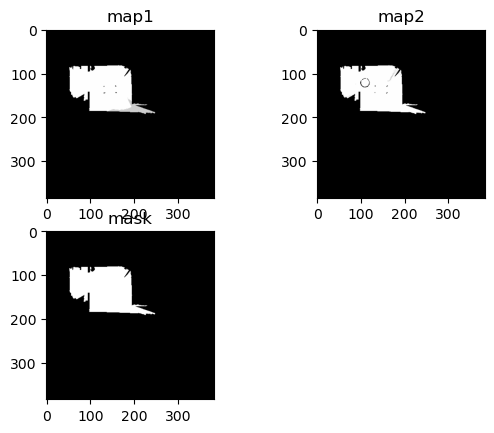

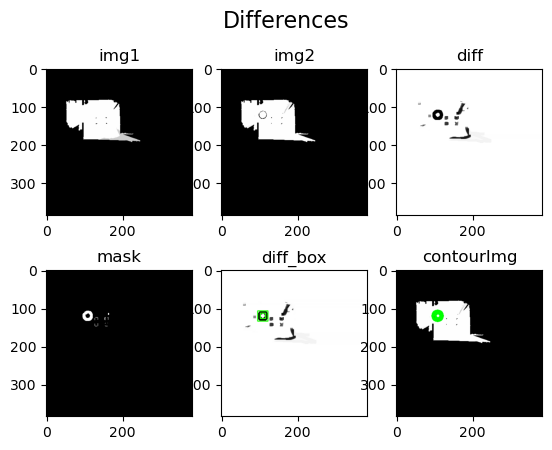

In [3]:
image1 = (image1 * mask).clip(0, 255).astype(np.uint8)
image2 = (image2 * mask).clip(0, 255).astype(np.uint8)
#DISPLAY
fig = plt.figure()
ax3 = fig.add_subplot(2,2,1)
ax3.imshow(image1,cmap='gray')
ax3.title.set_text('map1')

ax3 = fig.add_subplot(2,2,2)
ax3.imshow(image2)
ax3.title.set_text('map2')

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(mask)
ax3.title.set_text('mask')

printDifferences(image1,image2)